In [1]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import pandas as pd
from scipy.signal import savgol_filter, medfilt

In [2]:
data_dir = 'data/final_dataset'
test_file = 'data/final_dataset/output2_part226.mp4'

In [3]:
def measure_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return angle

def trunk_angle_calc(a, b):
    a = np.array(a)
    b = np.array(b)
    ba = (a-b)
    cosine_angle = np.dot(ba, np.array([0,0,1]))/(np.linalg.norm(ba)+1e-6)
    return np.arccos(np.clip(cosine_angle, -1.0, 1.0))

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
estimator = mp_pose.Pose(min_detection_confidence=0.8, min_tracking_confidence=0.8)

def extract_features_dataset(file_path):    
    cap = cv2.VideoCapture(file_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    count = 0
    pos = (50, 100)
    frames = []

    hip_vel_y = []
    hip_vel_x = []
    hip_y = []
    hip_x = []
    lower_foot = []
    left_knee_angle = []
    right_knee_angle = []
    hip_leg_angle = []
    trunk_angle = []
    
    rs = 12
    ls = 11
    lh = 23
    rh = 24
    lk = 25
    rk = 26
    la = 27
    ra = 28
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = estimator.process(frame)
        if results.pose_landmarks:
            if not results.pose_landmarks.landmark[ra].visibility>0.5:
                continue
            landmarks = [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
           
            hip_y.append((landmarks[lh][1]+landmarks[rh][1])/2)
            hip_x.append((landmarks[lh][0]+landmarks[rh][0])/2)
            lower_foot.append(min(landmarks[la][1], landmarks[ra][1]))
            left_knee_angle.append(measure_angle(landmarks[lh], landmarks[lk], landmarks[la]))
            right_knee_angle.append(measure_angle(landmarks[rh], landmarks[rk], landmarks[ra]))
            hip_leg_angle.append(measure_angle(landmarks[rs], landmarks[rh], landmarks[rk]))
    
            mid_shoulder = (np.array(landmarks[ls]) + np.array(landmarks[rs])) / 2
            mid_hip = (np.array(landmarks[lh]) + np.array(landmarks[rh])) / 2
        
            trunk_angle.append(trunk_angle_calc(mid_shoulder, mid_hip))
    
            if len(hip_y)>1:
                hip_vel_y.append((hip_y[-1] - hip_y[-2])*fps)
            else:
                hip_vel_y.append(0)
    
            if len(hip_x)>1:
                hip_vel_x.append((hip_x[-1] - hip_x[-2])*fps)
            else:
                hip_vel_x.append(0)
            frames.append(frame)
        #cv2.putText(frame, str(count), pos, cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3, cv2.LINE_AA)
        #cv2.imshow('', frame)
        #if cv2.waitKey(25) & 0xFF == ord('q'):
        #    break
    cap.release()
    cv2.destroyAllWindows()
    
    df = np.column_stack([hip_vel_y, hip_vel_x, hip_y, trunk_angle, left_knee_angle, right_knee_angle, hip_leg_angle, lower_foot])

    return df

I0000 00:00:1751663631.869445   25871 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1751663631.872879   25973 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-S)


In [5]:
def cluster_df(df, skip_frames=25):

    final_df = []
    
    features_smooth = savgol_filter(df, window_length=7, polyorder=3, axis=0)
    features_norm = (features_smooth - features_smooth.mean(axis=0)) / features_smooth.std(axis=0)
    
    kmeans = KMeans(n_clusters=4, random_state=0).fit(features_norm)
    labels = kmeans.labels_
    
    labels_smooth = medfilt(labels, kernel_size=7)
    
    labels_smooth = labels_smooth[skip_frames:]
    df = df[skip_frames:]
    final_df = []
    final_frames = []
    phase_order = []
    count  = 0
    
    for i in labels_smooth:
        if i in phase_order:
            continue
        else:
            phase_order.append(i)
    
    smoothen_labels = np.array([0 for i in range(len(labels_smooth))])
    
    for phase in phase_order:
        indices = np.where(labels_smooth == phase)[0]
        if len(indices) == 0:
            continue
        start = indices[0]
        end = indices[-1]
        smoothen_labels[start:end+1] = phase

    for idx, phase in enumerate(phase_order):
        final_frames = []
        while smoothen_labels[count] == phase:
            final_frames.append(df[count])
            
            count += 1
            if count == len(smoothen_labels):
                break
        final_df.append(final_frames)

    return final_df

In [10]:
def extract_segmented_features(directory):
    run_up = []
    take_off = []
    flight = []
    landing = []
    count = 0
    for file in os.listdir(directory):
        if not file.endswith('.mp4'):
            continue
        print(f'[LOG]: Processing {file}')
        path = os.path.join(directory, file)
        print(f'[LOG]: Extracting features from {file}')
        data = extract_features_dataset(path)
        dataframe_clip = cluster_df(data)
        print('[LOG]: Creating arrays')
        if len(dataframe_clip) == 4:
            run_up.append(dataframe_clip[0])
            take_off.append(dataframe_clip[1])
            flight.append(dataframe_clip[2])
            landing.append(dataframe_clip[3])
            count += 1
            print('[LOG]: Appending')
    print('[LOG]: Saving arrays')
    np.save('keypoints/run_up', np.array(run_up, dtype=object))
    np.save('keypoints/take_off', np.array(take_off, dtype=object))
    np.save('keypoints/flight', np.array(flight, dtype=object))
    np.save('keypoints/landing', np.array(landing, dtype=object))
    print(f'[LOG]: Done processing - {count}')

In [12]:
extract_segmented_features(data_dir)

[LOG]: Processing output2_part45.mp4
[LOG]: Extracting features from output2_part45.mp4
[LOG]: Creating arrays
[LOG]: Appending
[LOG]: Processing output4_part171.mp4
[LOG]: Extracting features from output4_part171.mp4
[LOG]: Creating arrays
[LOG]: Appending
[LOG]: Processing output4_part278.mp4
[LOG]: Extracting features from output4_part278.mp4
[LOG]: Creating arrays
[LOG]: Appending
[LOG]: Processing output4_part331.mp4
[LOG]: Extracting features from output4_part331.mp4
[LOG]: Creating arrays
[LOG]: Appending
[LOG]: Processing output0_part22.mp4
[LOG]: Extracting features from output0_part22.mp4
[LOG]: Creating arrays
[LOG]: Processing output2_part46.mp4
[LOG]: Extracting features from output2_part46.mp4
[LOG]: Creating arrays
[LOG]: Appending
[LOG]: Processing output4_part101.mp4
[LOG]: Extracting features from output4_part101.mp4
[LOG]: Creating arrays
[LOG]: Processing output4_part115.mp4
[LOG]: Extracting features from output4_part115.mp4
[LOG]: Creating arrays
[LOG]: Processing

In [13]:
arr = np.load('keypoints/flight.npy', allow_pickle=True)

In [18]:
(arr[0])

[array([0.03256053, 0.03743246, 0.55905217, 2.01009199, 1.85915112,
        2.42690624, 2.16262571, 0.60117787]),
 array([-0.14188588, -0.11557527,  0.55337673,  2.20583632,  1.71510164,
         2.28980464,  1.83601956,  0.59401798]),
 array([-0.27677789, -0.33089742,  0.54230562,  1.74763147,  2.8105221 ,
         2.57452199,  2.55699118,  0.70683998]),
 array([-0.74719116, -0.01637936,  0.51241797,  1.6788685 ,  1.79490414,
         2.8900676 ,  2.7116279 ,  0.60762376]),
 array([-0.39534457, -0.0719361 ,  0.49660419,  1.50622596,  1.87112997,
         2.53195976,  2.75268686,  0.6026718 ]),
 array([-0.54883324, -0.02009869,  0.47465086,  1.6254244 ,  2.67609777,
         2.61613545,  2.65344985,  0.60719776]),
 array([-0.24987571, -0.01134761,  0.46465583,  1.87024565,  2.57490641,
         1.8011542 ,  2.6672365 ,  0.57111299]),
 array([-0.59128925,  0.06412901,  0.44100426,  2.20025428,  2.37079316,
         2.40051209,  2.27387993,  0.60965729]),
 array([-0.26319288,  0.21993555

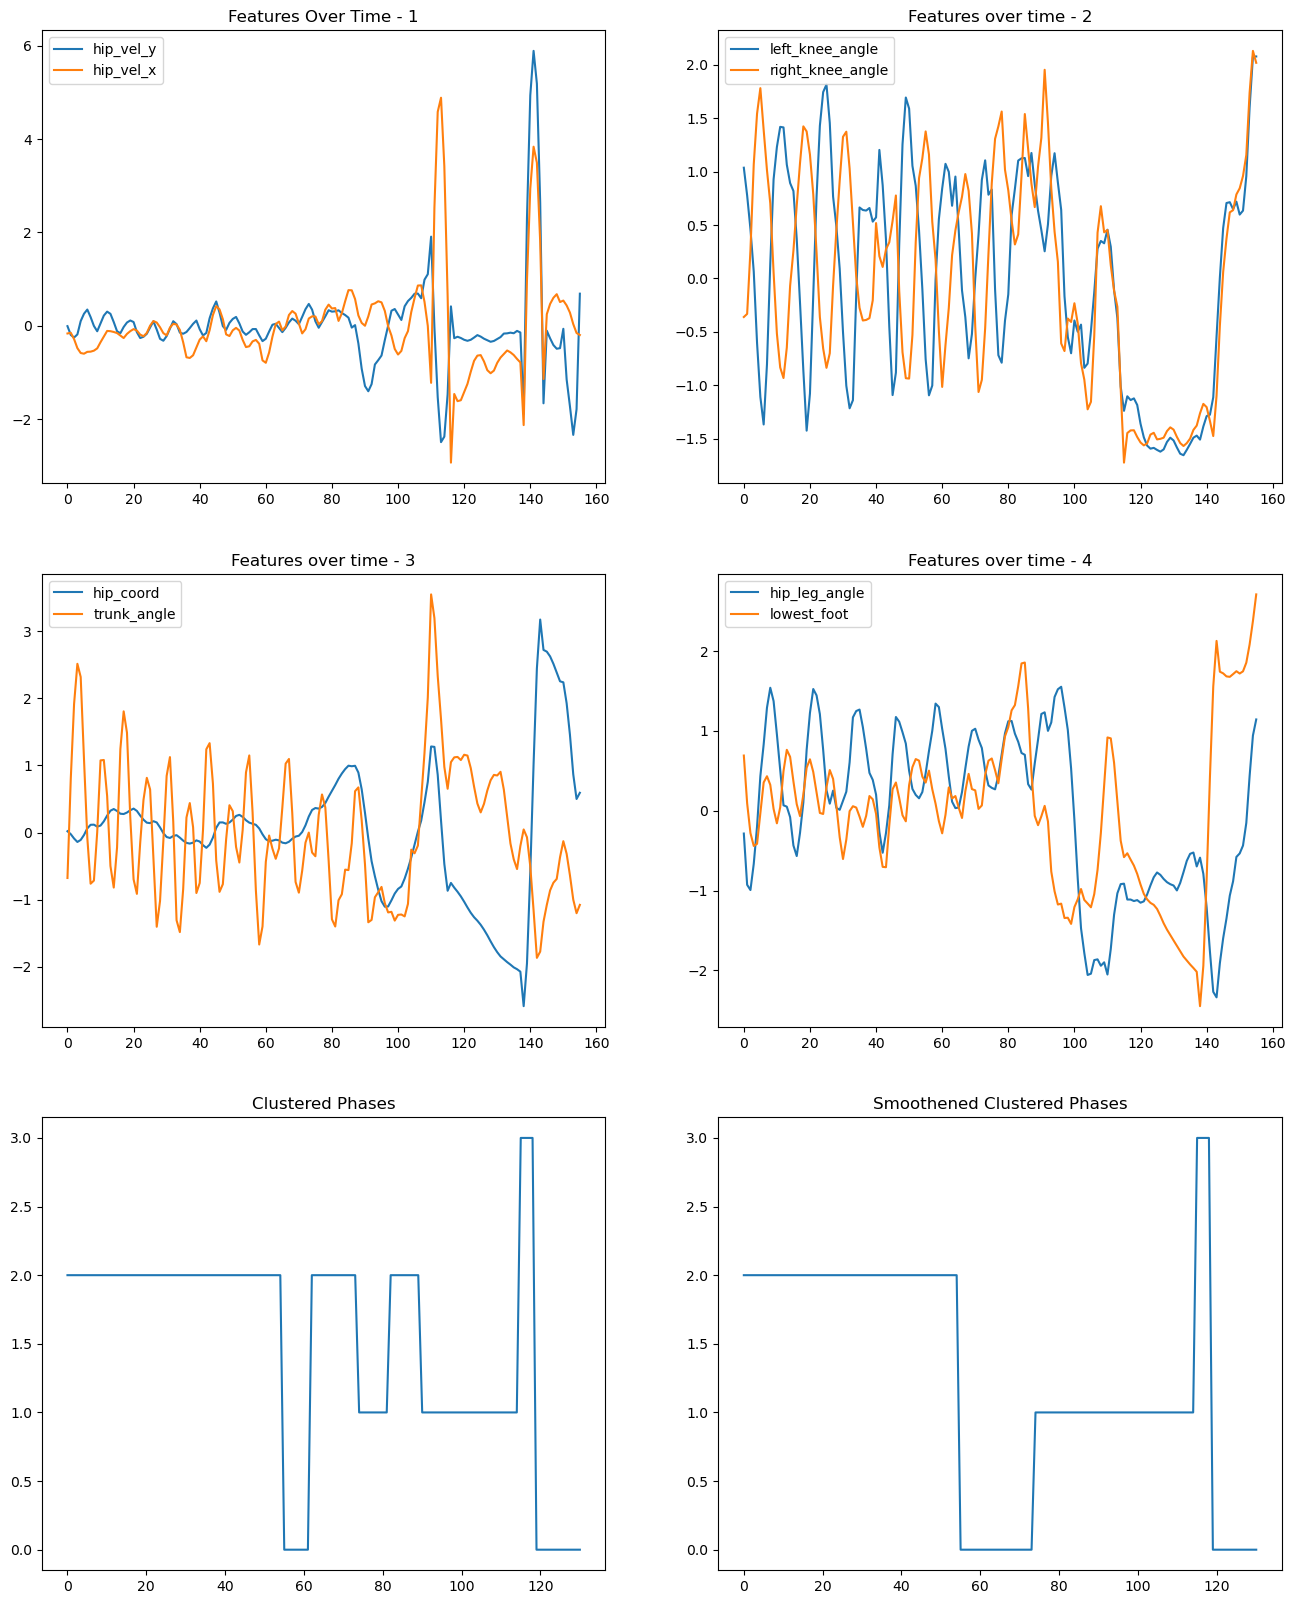

In [33]:
'''
plt.figure(figsize=(16, 20))
plt.subplot(3, 2, 1)
plt.plot(np.arange(len(hip_y)), features_norm[:, 0], label='hip_vel_y')
plt.plot(np.arange(len(hip_y)), features_norm[:, 1], label='hip_vel_x')
plt.legend()
plt.title('Features Over Time - 1')

plt.subplot(3, 2, 2)
plt.plot(np.arange(len(hip_y)), features_norm[:, 4], label='left_knee_angle')
plt.plot(np.arange(len(hip_y)), features_norm[:, 5], label='right_knee_angle')
plt.legend()
plt.title('Features over time - 2')

plt.subplot(3,2,3)
plt.plot(np.arange(len(hip_y)), features_norm[:, 2], label='hip_coord')
plt.plot(np.arange(len(hip_y)), features_norm[:, 3], label='trunk_angle')
plt.legend()
plt.title('Features over time - 3')

plt.subplot(3, 2, 4)
plt.plot(np.arange(len(hip_y)), features_norm[:, 6], label='hip_leg_angle')
plt.plot(np.arange(len(hip_y)), features_norm[:, 7], label='lowest_foot')
plt.legend()
plt.title('Features over time - 4')

plt.subplot(3,2,5)
plt.plot(np.arange(len(labels_smooth)), labels_smooth, label='Cluster')
plt.title('Clustered Phases')

plt.subplot(3,2,6)
plt.plot(np.arange(len(labels_smooth)), final_labels, label='Cluster')
plt.title('Smoothened Clustered Phases')

plt.show()
'''